# Voc segmentation

There is a dataset that contains images of objects from different classes — the Pascal Visual Object Classes (VOC). This page applies the UNet architecture to that dataset.

In [57]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import VOCSegmentation

from PIL import Image

import matplotlib.pyplot as plt

## Dataset

Consider dataset that will work with.

In [8]:
data_transforms = torchvision.datasets.vision.StandardTransform(
    transforms.ToTensor(), transforms.ToTensor()
)

train_dataset = VOCSegmentation(
    root='./voc_segmentation',
    year='2012',
    image_set='train',
    download=True
)
val_dataset = VOCSegmentation(
    root='./voc_segmentation',
    year='2012',
    image_set='val',
    download=True
)

Using downloaded and verified file: ./voc_segmentation/VOCtrainval_11-May-2012.tar
Extracting ./voc_segmentation/VOCtrainval_11-May-2012.tar to ./voc_segmentation
Using downloaded and verified file: ./voc_segmentation/VOCtrainval_11-May-2012.tar
Extracting ./voc_segmentation/VOCtrainval_11-May-2012.tar to ./voc_segmentation


As is typical in a segmentation task, it contains pictures and arrays of the same size as the labels, where each pixel represents the class of that pixel.

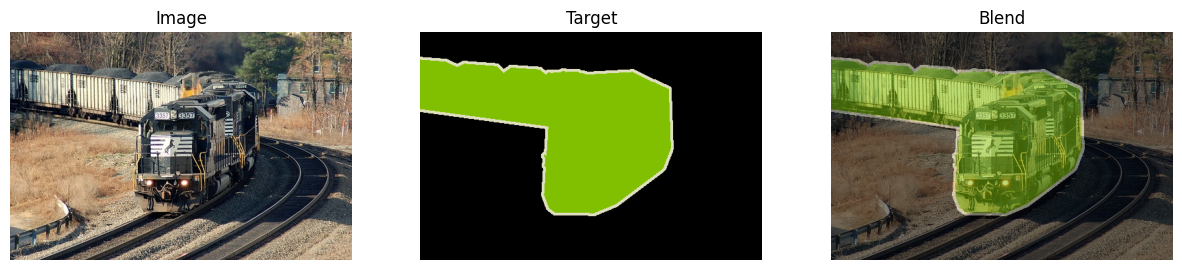

In [72]:
image, target = train_dataset[10]

plt.figure(figsize=(15, 10))

plt.subplot(131)
plt.imshow(image)
plt.title("Image")
plt.axis('off')

plt.subplot(132)
plt.imshow(target)
plt.title("Target")
plt.axis('off')

plt.subplot(133)
plt.imshow(Image.blend(
    im1=image,
    im2=target.convert('RGB'),
    alpha=0.5
))
plt.title("Blend")
plt.axis('off')


plt.show()

I found the following description of the labels for this task:

- 1: Aeroplane
- 2: Bicycle
- 3: Bird
- 4: Boat
- 5: Bottle
- 6: Bus
- 7: Car
- 8: Cat
- 9: Chair
- 10: Cow
- 11: Dining Table
- 12: Dog
- 13: Horse
- 14: Motorbike
- 15: Person
- 16: Potted Plant
- 17: Sheep
- 18: Sofa
- 19: Train
- 20: TV Monitor

But if you check values that are in the target of the arbitrary sample, it will be pictures from 0 to 1, which is not corresponds to the classes description below:

In [85]:
image, target = train_dataset[10]
torch.unique(transforms.ToTensor()(target))

tensor([0.0000, 0.0745, 1.0000])

The target has to be multiplied by 255 to obtain the labels. The following cell shows the unique numbers and their of the target multiplied by 255 for a purposely selected picture from the training set.

In [96]:
ans = torch.unique(transforms.ToTensor()(target)*255, return_counts=True)
dict(zip([v.item() for v in ans[0]], [v.item() for v in ans[1]]))

{0.0: 115576, 19.0: 46635, 255.0: 4289}

There are the numbers 0, 19, and 255. The number 19 obviously corresponds to pixels in the train. Based on the counts, it appears that 0 corresponds to the background pixels and 255 corresponds to the border pixels.

According to the information discovered earlier, we are constructing our target values.

In [120]:
transforms = torchvision.datasets.vision.StandardTransform(
    transform=transforms.ToTensor(), 
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x*255).long()),
        transforms.Lambda(lambda x: torch.where(x==255, 21, x))
    ])
)

train_dataset.transforms = transforms
val_dataset.transforms = transforms